In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import shapefile
import pyproj


#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform

# plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob

In [2]:
from matplotlib.path import Path

In [3]:
def getPolyCoords(row, geom, coord_type):
    """
    Returns the coordinates ('x|y') of edges/vertices of a Polygon/others
    Args:
    - row: the row object from a geodataframe; i.e.   df.loc[1]
    - geom: the name of "geometry" column, usually "geometry"
    - coord_type: 'x', or 'y'
    ...
    Valid geometrie types 'Polygon', 'Point', 'LineString', 'MultiLineString', 'MultiPolygon'
    """

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        # updated code, using .geoms
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []

Try to plot the amery boundaries:

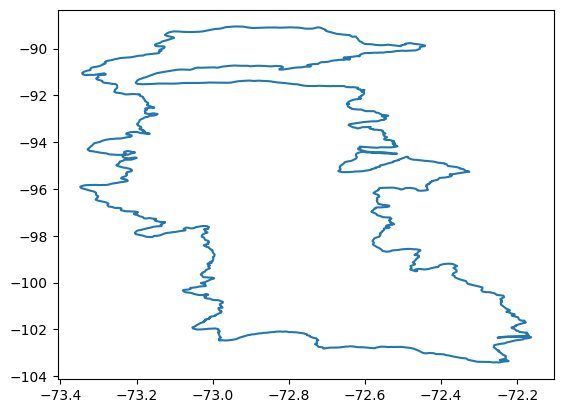

In [4]:
shelf = gpd.read_file('/raid01/mafields/tas/MODELS_filtered/ssp585/shape_files/Abbot.shp') 
shelf.crs = "EPSG:3031"
shelf = shelf.to_crs(epsg=4326)

shelf_lon = getPolyCoords(shelf.loc[0], 'geometry', 'x')
shelf_lat = getPolyCoords(shelf.loc[0], 'geometry', 'y')
shelf_list = np.vstack([shelf_lat,shelf_lon]).T
shelf_path = Path(shelf_list)

plt.plot(shelf_lat,shelf_lon)

#print(np.where(shelf_lon < 0))

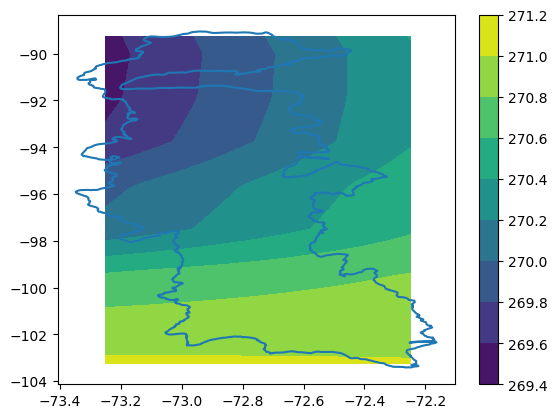

In [5]:
shelf_data = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/abbot/monthly/C5M1.CSIRO-Mk3-6-0.monavg.monavg.25deg.abbot.nc'

#Reading in Datafiles
fname = shelf_data
datain = Dataset(fname, 'r')
#print(datain)
        
##Splitting The Path to label the models
head_tail = os.path.split(fname) #makes the path a variable
mystring = str(head_tail[1]) #turns the variable into a string
x = mystring.split(".", 5)#parsing the model name by periods
        
#Creating Variables
var = datain.variables['tas'] #2meter surface temperture
gridsize = var[1].size
lat = datain.variables['latitude'][:] #latitude
lon = datain.variables['longitude'][:] #longitude
timevar = datain.variables['time'] #in days since 1850
dtime = num2date(timevar[:],timevar.units) # The next two lines make the time variable readable
ym = np.zeros((len(dtime),2), int)

for i in range(len(dtime)): #Creating an aray of years from the time variable
    ym[i,0] = dtime[i].year



shelf_lon_model, shelf_lat_model = np.meshgrid(lon,lat)
plt.contourf(shelf_lat_model,shelf_lon_model,var[0])
plt.colorbar()
plt.plot(shelf_lat,shelf_lon)



In [1]:
inds = shelf_path.contains_points(np.vstack([shelf_lat_model.ravel(), shelf_lon_model.ravel()]).T)
print(inds)

plt.scatter(shelf_lat_model.ravel()[inds], shelf_lon_model.ravel()[inds])
plt.plot(shelf_lat,shelf_lon)


NameError: name 'shelf_path' is not defined

5282


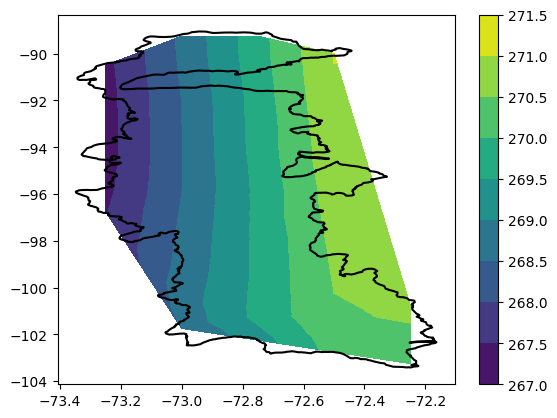

In [19]:
var = datain.variables['tas'] #2meter surface temperture
print(len(var))

lat_temp = shelf_lat_model.ravel()[inds]
lon_temp = shelf_lon_model.ravel()[inds]

testvar = var[0].reshape((1,len(inds)))

plt.tricontourf(lat_temp,lon_temp,testvar[0][inds])
plt.plot(shelf_lat,shelf_lon, c='k')
plt.colorbar()
